In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import pickle
import argparse
import torch
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report
from pathlib import Path
import seaborn as sns
import random
sys.path.insert(0, '..')
from config import *
from util.plot_utils import obtain_plot, plot_logs
from tqdm.notebook import tqdm
from train_binary_cl import get_args_parser, create_data_loader_test
from models.mlp import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [3]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'nt')

In [4]:
folder_name = 'NTlayer30_dividing_factor20_hiddenlayers1'

# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, folder_name, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(args.output_dir, 'best_model.pth')

In [5]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test  = os.path.join(rna_rna_files_dir, "gene_pairs_test.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_val  = os.path.join(rna_rna_files_dir, "gene_pairs_val.txt")
with open(file_val, "rb") as fp:   # Unpickling
    gene_pairs_val = pickle.load(fp)

In [6]:
set_data = 'testval' 
assert set_data in ['val', 'testval']
folder_path = os.path.join(args.layer_folder, f'{set_data}')
done = list(pd.read_csv(os.path.join(metadata_dir,f'done_{set_data}.txt'), header = None)[0])
excluded = list(pd.read_csv(os.path.join(metadata_dir,f'excluded_{set_data}.txt'), header = None)[0])
meta = pd.read_csv(os.path.join(metadata_dir, f'{set_data}.csv'))
meta = meta[meta.id_sample.isin(done)]
meta = meta[~meta.id_sample.isin(excluded)]

#only test
#meta = meta[meta.couple.isin(gene_pairs_test)]

In [7]:
device = torch.device(args.device)
model = build_model(args)
model.to(device)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [9]:
start_time = time.time()
model.eval()

probability = []
ground_truth = []
g1 = []
g2 = []
policy = []
len_g1 = []
len_g2 = []
couple_id = []
original_length1 = []
original_length2 = []
id_sample = []

for _, row in tqdm(meta.iterrows(), total =meta.shape[0] ):
    class_label = 'class_1' if row.interacting else 'class_0'
    class_folder = os.path.join(folder_path, class_label)
    sample_file = str(row.id_sample) + '.npy'
    sample = np.load(os.path.join(class_folder, sample_file))
    inputs = torch.from_numpy(np.expand_dims(sample, axis = 0)).float().to(device)
    outputs = model(inputs)
    probability += outputs.softmax(-1)[:, 1].tolist()
    
    ground_truth.append(1 if row.interacting else 0)
    policy.append(row['policy'])
    couple_id.append(row['couple'])
    g1.append(row['gene1'])
    g2.append(row['gene2'])
    len_g1.append(row.x2 - row.x1)
    len_g2.append(row.y2 - row.y1)
    original_length1.append(row['original_length1'])
    original_length2.append(row['original_length2'])
    id_sample.append(row.id_sample)

res = pd.DataFrame({
    'id_sample':id_sample,
    'probability':probability,
    'ground_truth':ground_truth,
    'g1':g1,
    'g2':g2,
    'policy':policy,
    'len_g1': len_g1,
    'len_g2': len_g2,
    'couples':couple_id,
    'original_length1':original_length1,
    'original_length2':original_length2
})

res['prediction'] = (res['probability'] > 0.5).astype(int)

(res['prediction'] == res['ground_truth']).sum()/res.shape[0]

res['sampled_area'] = res['len_g1']*res['len_g2']

res['matrix_area'] = res['original_length1']*res['original_length2']

  0%|          | 0/76318 [00:00<?, ?it/s]

In [10]:
print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.58      0.54      0.56     38137
           1       0.57      0.61      0.59     38181

    accuracy                           0.58     76318
   macro avg       0.58      0.58      0.58     76318
weighted avg       0.58      0.58      0.58     76318



# PLOTS

### Log plots

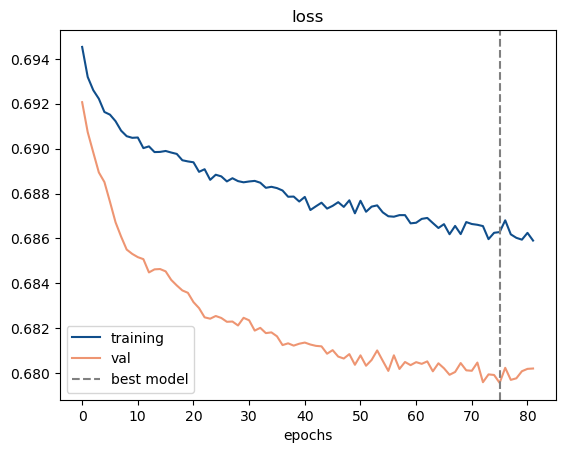

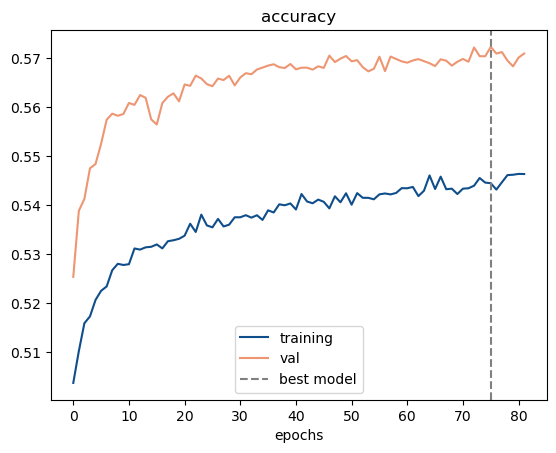

In [53]:
#epoch 1110 validation is fixed!
folder_name = 'NTlayer22_dividing_factor20_hiddenlayers2'
folder_name = 'NTlayer30_dividing_factor80_hiddenlayers3'
folder_name = 'NTlayer30_dividing_factor10_hiddenlayers2'
folder_name = 'NTlayer30_dividing_factor20_hiddenlayers2'
folder_name = 'NTlayer30_dividing_factor20_hiddenlayers1'
log = pd.read_json(Path(os.path.join(ROOT_DIR, 'checkpoints', 'nt', folder_name, 'log.txt')), lines=True)
best_model = np.argmax(log.test_accuracy) #np.argmin(log.test_loss)
for metric in ['loss', 'accuracy']:
    plot_logs(log, metric, best_model = best_model)

## Metrics

In [31]:
df = pd.read_csv(os.path.join(processed_files_dir,"final_df.csv"), sep = ',')[['couples', 'protein_coding_1', 'protein_coding_2']]
assert df.merge(res, on = 'couples').shape[0] >= res.shape[0]
if df.merge(res, on = 'couples').shape[0] > res.shape[0]:
    print(f"Be careful, some prediction will be counted more than one time. The number of duplicated sequences is {(df.merge(res, on = 'couples').shape[0]-res.shape[0])}")

res = df.merge(res, on = 'couples')
res=res.rename({'protein_coding_1': 'gene1_pc'}, axis = 1)
res=res.rename({'protein_coding_2': 'gene2_pc'}, axis = 1)

df_genes = pd.read_csv(os.path.join(processed_files_dir,"df_genes.csv"), sep = ',')[['gene_id', 'species_set']]
res = res.merge(df_genes, left_on = 'g1', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'species_set':'specie'}, axis = 1)
res['specie'] = res.specie.str.replace("{'hs'}", "human")
res['specie'] = res.specie.str.replace("{'mm'}", "mouse")

Be careful, some prediction will be counted more than one time. The number of duplicated sequences is 378


/tmp/ipykernel_671308/1589123165.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  res['specie'] = res.specie.str.replace("{'hs'}", "human")
/tmp/ipykernel_671308/1589123165.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  res['specie'] = res.specie.str.replace("{'mm'}", "mouse")


In [32]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

1    41002
0    35694
Name: prediction, dtype: int64


1    38559
0    38137
Name: ground_truth, dtype: int64


In [15]:
n_conf = 10

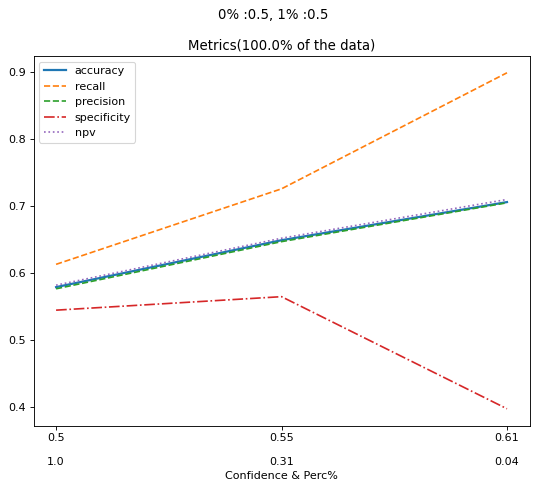

In [16]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

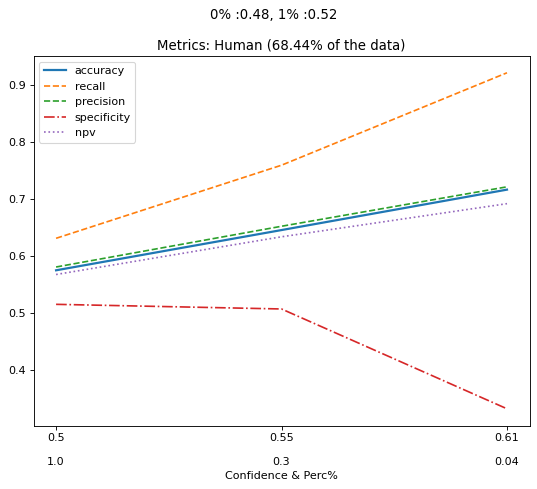

In [17]:
human = res[(res.specie == 'human')]
obtain_plot(human, n_original_df = res.shape[0], title = f'Metrics: Human ', n_conf = n_conf)

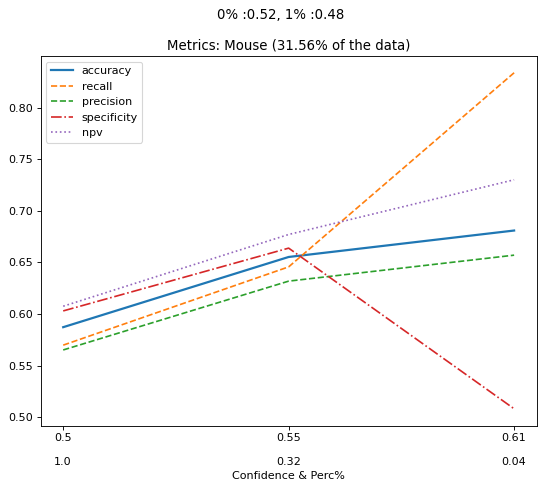

In [18]:
mouse = res[(res.specie == 'mouse')]
obtain_plot(mouse, n_original_df = res.shape[0], title = f'Metrics: Mouse ', n_conf = n_conf)

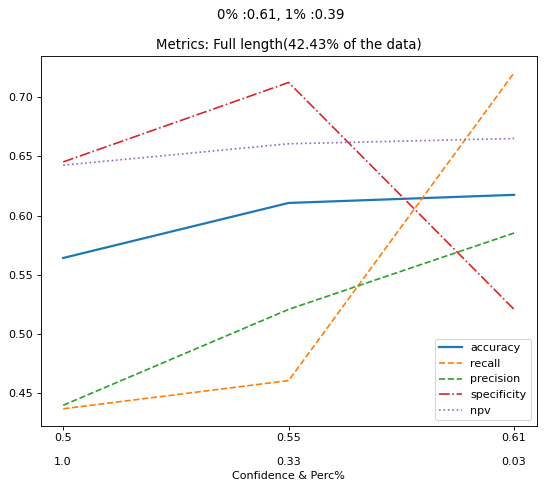

In [19]:
full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
full_length = full_length[(full_length.policy == 'easypos')|(full_length.policy == 'smartneg')]
obtain_plot(full_length, n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = n_conf)

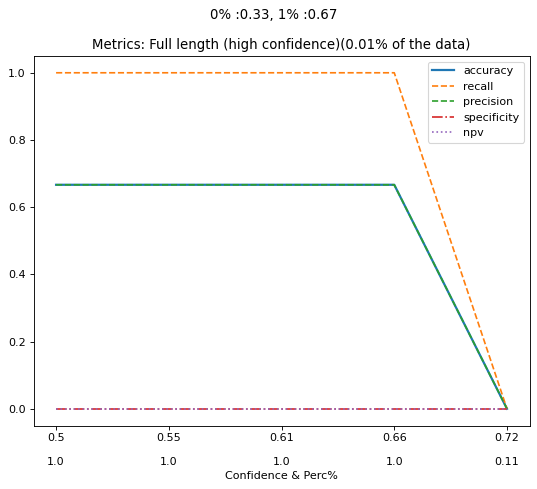

In [20]:
confidence_level = 0.7
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]
obtain_plot(high_conf_fl, n_original_df = res.shape[0], title = f'Metrics: Full length (high confidence)', n_conf = n_conf)

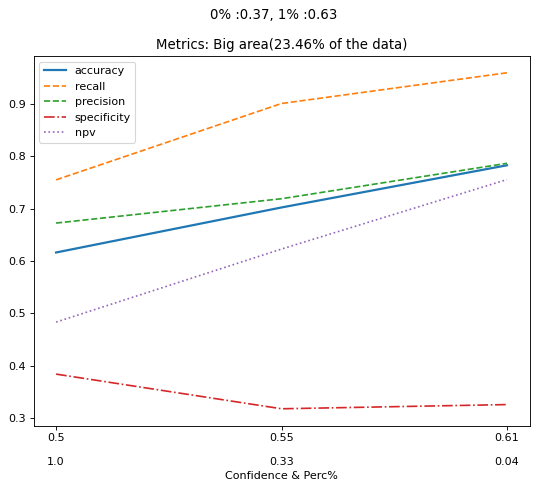

In [21]:
big_area_size = res.sampled_area.quantile(0.8)
big_area_size = 5000**2
big_area = res[res['sampled_area'] > big_area_size]

obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

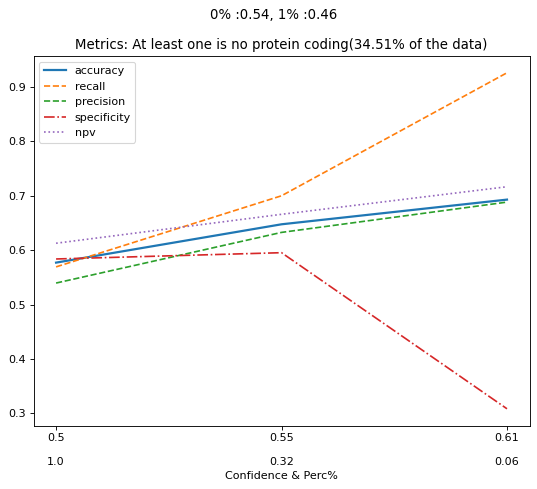

In [22]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(no_pc, n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

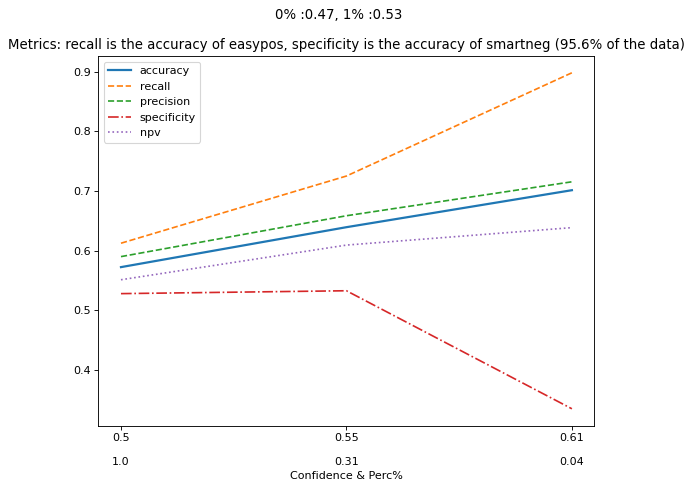

In [23]:
easypos_smartneg = res[(res.policy == 'easypos')|(res.policy == 'smartneg')]

obtain_plot(easypos_smartneg, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)

0.8923766816143498


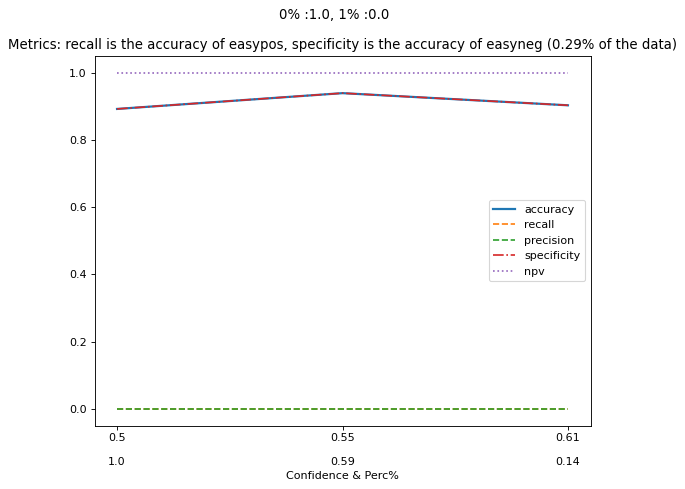

In [24]:
easy = res[(res.policy == 'easyneg')]
easy = easy[(easy.original_length1>MAX_RNA_SIZE)&(easy.original_length2>MAX_RNA_SIZE)]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of easyneg ', n_conf = n_conf)

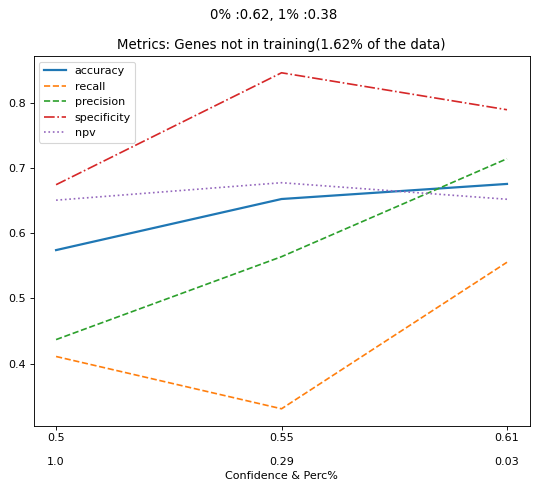

In [25]:
df_train = pd.DataFrame({'couples':gene_pairs_train})
regex = df_train['couples'].str.extractall('(.*)_(.*)').reset_index()
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.g1.isin(df_train_genes) | res.g2.isin(df_train_genes))]

obtain_plot(not_in_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

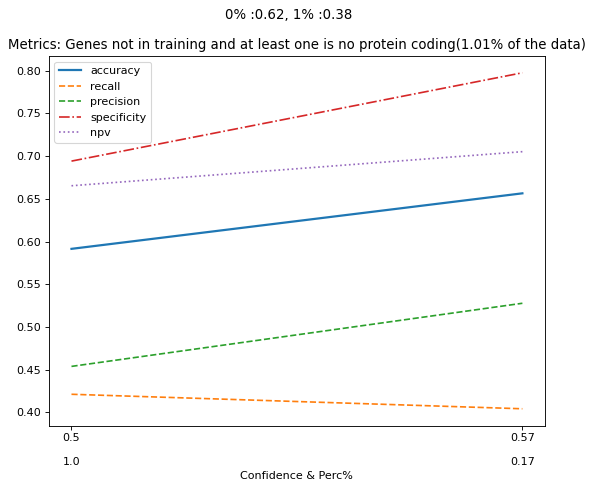

In [26]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = 8)

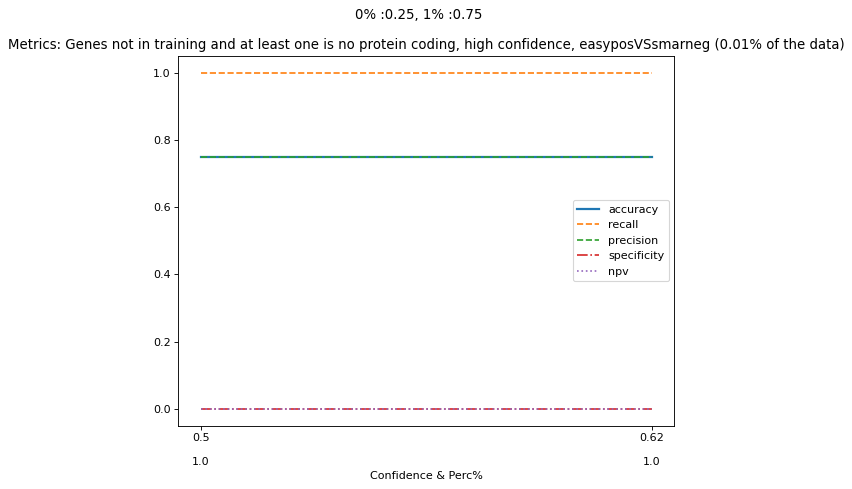

In [33]:
confidence_level = 0.7

no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.probability>confidence_level)|(no_pc_no_train.probability<(1-confidence_level))]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.policy == 'easypos')|(no_pc_no_train.policy == 'smartneg')]
obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, high confidence, easyposVSsmarneg ', n_conf = 5, excluding_treshold = 0.2)

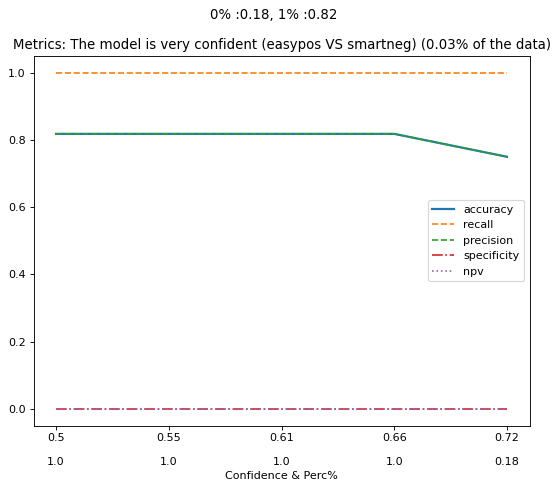

In [34]:
confidence_level = 0.7
high_prob_pairs = res[(res.probability>confidence_level)|(res.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)